In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp_analysis = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
filter(Measurement.date <= "2017-08-23").all()
prcp_analysis

old_date = prcp_analysis[0]
old_date


('2016-08-23', 0.0)

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_analysis)
prcp_df['date'] = pd.to_datetime(prcp_df['date'])

In [15]:
# Sort the dataframe by date
prcp_df = prcp_df.set_index('date')
prcp_df.rename(columns = {'prcp': 'Precipitation'}, inplace=True)
prcp_df.head()

,Precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


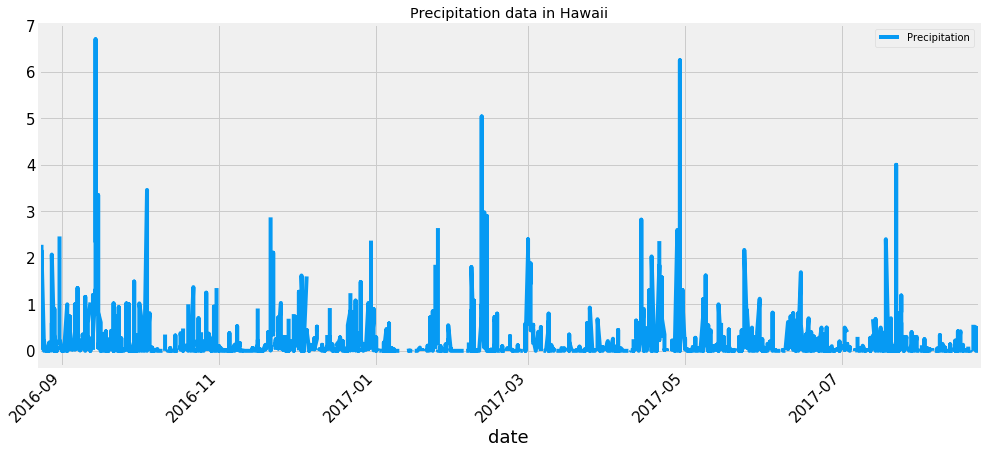

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(15, 7),
            sort_columns=True,
            rot=45,
            use_index=True,
            title='Precipitation data in Hawaii',
            legend=True,
            fontsize=15,
            grid=True,
            color='xkcd:azure'
            )
plt.xlabel('date', fontsize=18)
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
print(f'There are {station_count} stations available in this dataset.')

There are 9 stations available in this dataset.


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()


[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [21]:
# Using the station id from the previous query (USC00519281), calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Measurement.station, Station.name, func.min(Measurement.tobs), func.max(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.station == Station.station).all()





[('USC00519281', 'WAIHEE 837.5, HI US', 54.0, 85.0)]

In [22]:
# prcp_analysis = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
# filter(Measurement.date <= "2017-08-23").all()
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Waikiki_station = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date > old_date).all()
# session.query(Measurement.date, Measurement.tobs)

InterfaceError: (sqlite3.InterfaceError) Error binding parameter 1 - probably unsupported type.
[SQL: SELECT measurement.date AS measurement_date, measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.station = ? AND measurement.date > ?]
[parameters: ('USC00519281', ('2016-08-23', 0.0))]
(Background on this error at: http://sqlalche.me/e/rvf5)

![precipitation](Images/station-histogram.png)

In [47]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

start_date = '2017-06-17'
end_date = '2017-06-23'
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
calc_temps17 = (calc_temps('2017-06-17', '2017-06-23'))
print (calc_temps17)

[(71.0, 76.6590909090909, 82.0)]


In [48]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

calc_temps16 = (calc_temps('2016-06-17', '2016-06-23'))
print (calc_temps16)

[(69.0, 75.65957446808511, 80.0)]


In [65]:
temp17_df = pd.DataFrame(calc_temps17, columns=[
    "min temp",
    "avg temp",
    "max temp"
])
temp17_df.head

<bound method NDFrame.head of    min temp   avg temp  max temp
0      71.0  76.659091      82.0>

In [64]:
temp16_df = pd.DataFrame(calc_temps16, columns=[
    "min temp",
    "avg temp",
    "max temp"
])
temp16_df.head

<bound method NDFrame.head of    min temp   avg temp  max temp
0      69.0  75.659574      80.0>

In [77]:
temp16_df.set_index([pd.Index([1])])

,min temp,avg temp,max temp
1,69.0,75.659574,80.0


In [76]:
temp17_df.set_index([pd.Index([1])])

,min temp,avg temp,max temp
1,71.0,76.659091,82.0


In [85]:
# temp16_df.set_index([pd.Index([1])])
# temp17_df.set_index([pd.Index([1])])

temp_calc = temp17_df.merge(temp16_df,  how='outer', suffixes=['_17','_16'], left_index=True, right_index=True)
temp_calc



,min temp_17,avg temp_17,max temp_17,min temp_16,avg temp_16,max temp_16
0,71.0,76.659091,82.0,69.0,75.659574,80.0


/Users/robertorobles/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


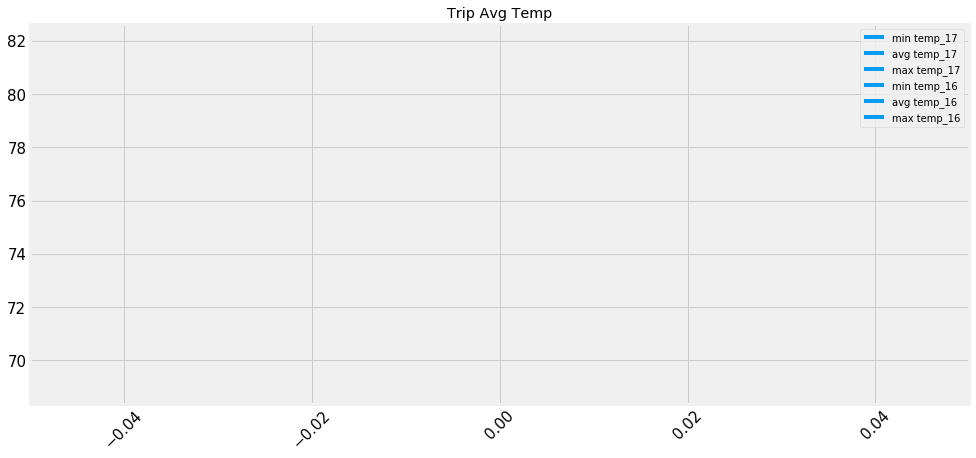

In [86]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)




In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the
# previous year's matching dates.

# Sort this in descending order by precipitation amount and list the station, name, 
# latitude, longitude, and elevation

